<a href="https://colab.research.google.com/github/solharsh/Computer_Vision/blob/master/CNN_Gluon_Image_Classification_Luggage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import pickle

#drive.mount('/content/drive')
DATA_PATH = "/content/drive/My Drive/Computer_vision/"
infile = open(DATA_PATH+'/training_data.pkl','rb')
df = pickle.load(infile)

In [2]:
df.head()

,data,label
0,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",4
1,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",1
2,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",4
3,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",3
4,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",1


- Class 0: two wheels 
- Class 1: four wheels 
- Class 2: zero wheels 
- Class 3: not a wheel 
- Class 4: inconclusive

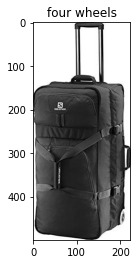

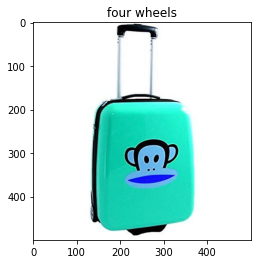

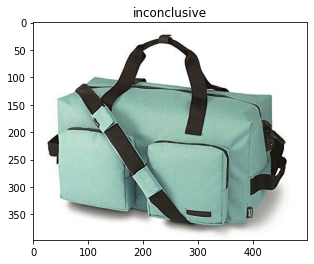

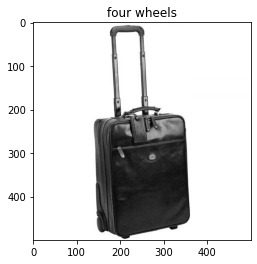

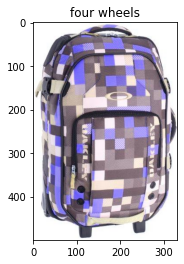

In [3]:
#Let's plot some images below.

import matplotlib.pyplot as plt

classes = ['two wheels', 'four wheels', 'zero wheels', 'not a wheel', 'inconclusive']

plt.imshow(df["data"][551])
plt.title(classes[df["label"][551]])
plt.show()

plt.imshow(df["data"][1119])
plt.title(classes[df["label"][1119]])
plt.show()

plt.imshow(df["data"][156])
plt.title(classes[df["label"][156]])
plt.show()

plt.imshow(df["data"][1526])
plt.title(classes[df["label"][1526]])
plt.show()

plt.imshow(df["data"][15])
plt.title(classes[df["label"][15]])
plt.show()

2. SPLIT THE DATASET AND PROCESS IMAGES
* We split the original dataset into Training (80%), Validation (10%) and Test (10%) subsets.
* We will process images by resizing to 224x224 and converting (row, column, channel) to (channel, row, column)

In [4]:
!pip install mxnet

In [0]:
import numpy as np
from skimage.transform import resize
from mxnet import gluon

# Let's split to data into training (80%), validation (10%) and test (10%) subsets.
train_indices = np.arange(0, int(0.8*len(df)))
val_indices = np.arange(int(0.8*len(df)), int(0.9*len(df)))
test_indices = np.arange(int(0.9*len(df)), len(df))

train_df = df.iloc[train_indices]
val_df = df.iloc[val_indices]
test_df = df.iloc[test_indices]

del df

def getImages(images):
    # Create the image holder array
    image_arr = np.zeros((images.shape[0], 3, 224, 224), dtype="float32")
    
    # Iterate through the image data
    for i, im in enumerate(images):
        # Get image from the data column of the current row
        
        # We need a fixed size input, our images have different sizes, let's pick 224x224.
        # Resize image below
        im = resize(im, output_shape=(224, 224))
        
        # Gluon/mxnet expects images in this format (channel, row, column)
        # This is the opposite of (row, column, channel), let's fix it
        im = np.moveaxis(im, -1, 0)
        
        # Assign the value in the image array
        image_arr[i] = im

    return image_arr
    
train_images, train_labels = getImages(train_df["data"].values), train_df["label"].values
validation_images, validation_labels = getImages(val_df["data"].values), val_df["label"].values

# Using Gluon Data loaders to load the data in batches
train_dataset = gluon.data.ArrayDataset(train_images, train_labels)
validation_dataset = gluon.data.ArrayDataset(validation_images, validation_labels)

# 3. Plot the class distribution

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


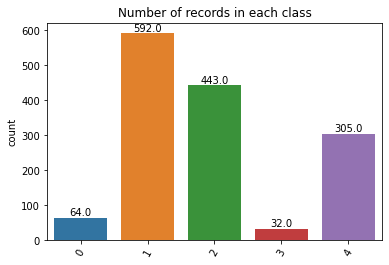

In [6]:
import matplotlib.pyplot as plt
import seaborn as sb

plt.figure()
ax = sb.countplot(x=train_labels, y = None)
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate(y, (x.mean(), y), ha='center', va='bottom') 
plt.xticks(rotation=60)
plt.title('Number of records in each class')
plt.show()

# 4. CONFUSION MATRIX
We have the following function to plot confusion matrix. We will call this function to plot confusion matrix for our validation data after each epoch (one full pass through the training dataset)

In [0]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index = [i for i in ['two wheels', 'four wheels', 'zero wheels', 'not a wheel', 'inconclusive']], columns = [i for i in ['two wheels', 'four wheels', 'zero wheels', 'not a wheel', 'inconclusive']])
    plt.figure(figsize = (5, 5))
    plt.title('Validation Confusion Matrix')
    sn.heatmap(df_cm, annot=True)
    plt.show()

# 5. Training and Validation
#### We will do the following:
#### * Create a simple Convolutional Neural Network (2 conv-pool pairs + flattening + softmax)
#### * Use the following hyper-parameters: batch size, epochs, learning rate. You can experiment with different values, but we will discuss those in greater detail tomorrow
#### * Calculate the loss and accuracy for training and validation at each epoch and print them at the end of each epoch.
#### * Plot the confusion matrix at the end of each epoch. 

Epoch 0, training loss: 1.31, validation loss: 1.38, training accuracy: 0.40, validation accuracy: 0.36


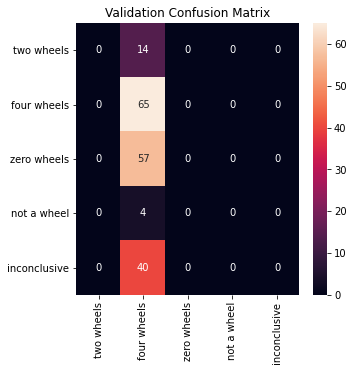

Epoch 1, training loss: 1.25, validation loss: 1.38, training accuracy: 0.43, validation accuracy: 0.36


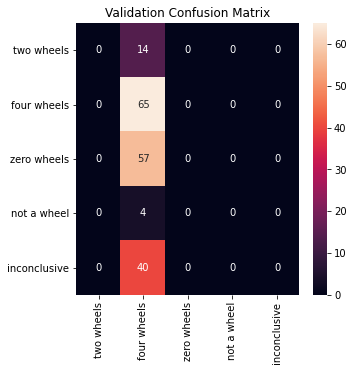

Epoch 2, training loss: 1.23, validation loss: 1.37, training accuracy: 0.44, validation accuracy: 0.36


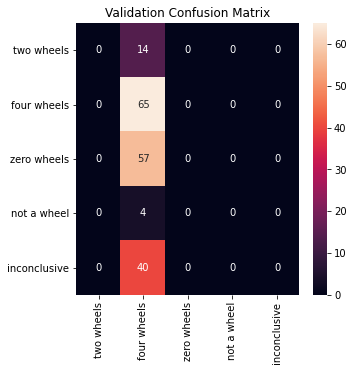

In [8]:
import mxnet as mx
from mxnet import gluon, autograd, ndarray
from mxnet.gluon.loss import SoftmaxCrossEntropyLoss
import mxnet.ndarray as nd
from sklearn.metrics import accuracy_score

# Set this to CPU or GPU depending on your training instance
ctx = mx.cpu()
#ctx = mx.gpu()

# Hyper-paramaters of the system
batch_size = 64
epochs = 3
learning_rate = 0.01

# Create the network. We have 5 classes
num_outputs = 5
    
net = gluon.nn.Sequential()
with net.name_scope():
    net.add(gluon.nn.Conv2D(channels=20, kernel_size=5, activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
    net.add(gluon.nn.Conv2D(channels=60, kernel_size=3, activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
    # The Flatten layer collapses all axis, except the first one, into one axis.
    net.add(gluon.nn.Flatten())
    net.add(gluon.nn.Dense(512, activation="relu"))
    net.add(gluon.nn.Dense(num_outputs))
    
# Initialize parameters
net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)

# Define loss and trainer.
softmax_cross_etropy_loss = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': learning_rate})

train_loader = gluon.data.DataLoader(train_dataset, batch_size=batch_size)
validation_loader = gluon.data.DataLoader(validation_dataset, batch_size=batch_size)

# Starting the outer loop, we will have 3 epochs (3 full pass through our dataset)
for epoch in range(epochs):
    
    # Training loop: (with autograd and trainer steps, etc.)
    # This loop does the training of the neural network (weights are updated)
    cumulative_train_loss = 0
    train_predictions = []
    for i, (data, label) in enumerate(train_loader):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            train_predictions = train_predictions + np.argmax(output.asnumpy(), axis=1).tolist()
            loss = softmax_cross_etropy_loss(output, label)
            cumulative_train_loss = cumulative_train_loss + nd.sum(loss)
        loss.backward()
        trainer.step(data.shape[0])
    
    # Calculating the Softmax Cross Entopy Loss for training
    train_loss = cumulative_train_loss/len(train_images)

    # Validation loop:
    # This loop tests the trained network on validation dataset
    # No weight updates here
    cumulative_valid_loss = 0
    val_predictions = []
    for i, (data, label) in enumerate(validation_loader):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = net(data)
        val_predictions = val_predictions + np.argmax(output.asnumpy(), axis=1).tolist()
        val_loss = softmax_cross_etropy_loss(output, label)
        cumulative_valid_loss = cumulative_valid_loss + nd.sum(val_loss)
    valid_loss = cumulative_valid_loss/len(validation_images)

    # Calculate training and validation accuracies
    # I used a accuracy_score() function from the sklearn library here. 
    # accuracy = (TP+TN) / (TP+FP+TN+FN)
    train_accuracy = accuracy_score(train_labels.tolist(), train_predictions)
    validation_accuracy = accuracy_score(validation_labels.tolist(), val_predictions)
    
    # Print the summary and plot the confusion matrix after each epoch
    print("Epoch {}, training loss: {:.2f}, validation loss: {:.2f}, training accuracy: {:.2f}, validation accuracy: {:.2f}".format(epoch, train_loss.asnumpy()[0], valid_loss.asnumpy()[0], train_accuracy, validation_accuracy))
    plot_confusion_matrix(validation_labels.tolist(), val_predictions)

# 6. Test on test dataset
#### We are done with the training and validation. Let's get the test predictions below. We will also write them to a __CSV__ file in a similar way to our __Final Project__. 

In [9]:
test_images = getImages(test_df["data"].values)
test_loader = gluon.data.DataLoader(test_images, batch_size=batch_size)

test_predictions = []
for i, data in enumerate(test_loader):
    data = data.as_in_context(ctx)
    output = net(data)
    test_predictions = test_predictions + np.argmax(output.asnumpy(), axis=1).tolist()
print(test_predictions)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
